In [65]:
#imports
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.nn.functional as F
from torch.autograd import Variable # storing data while learning
from torch.distributions import constraints, multivariate_normal, Normal
from torch.distributions.distribution import Distribution
from torch.utils.data import DataLoader, Dataset


## First loading the recorded data

In [66]:
class CoordinateDataset(Dataset):
    
    def __init__(self, file_name, with_scaler=False):
        file_out = pd.read_csv(file_name, names=['ball_x', 'ball_y', 'positionLeftShoulderRoll', 'positionLeftShoulderPitch'])
        print(f"Number of samples: {len(file_out)}")
        file_out.drop_duplicates(subset=['ball_x','ball_y'], inplace=True)
        print(f"Number of samples after removing duplicates: {len(file_out)}")
        x = file_out[['ball_x','ball_y']].values
        y = file_out[['positionLeftShoulderRoll', 'positionLeftShoulderPitch']].values
        x_train = x
        if with_scaler:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
        y_train = y
        x_tensor = torch.tensor(x_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32)
        self.x_train = Variable(x_tensor)
        self.y_train = Variable(y_tensor, requires_grad=False)
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]
        
dataset = CoordinateDataset('../controllers/tutorial2_tracker/data_points.csv')

Number of samples: 160
Number of samples after removing duplicates: 72


## Then training the MDN

In [67]:
class MDN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        
        #IMPORTANT notes
        # - Use softmax activation for pi  (they need to add up to 1)
        # - Use exponential linear unit for deviations (they should not be negative or close to zero)
        self.pis = nn.Linear(n_hidden, n_gaussians) # Coefficents
        self.mus = nn.Linear(n_hidden, n_gaussians * n_output) # Means
        self.sigmas = nn.Linear(n_hidden, n_gaussians) # Variances / Deviations
        

    def forward(self, x):
        #Program the forward pass
        x = torch.tanh(self.fc1(x))
        pi = F.softmax(self.pis(x), -1)
        sigma = torch.exp(self.sigmas(x))
        mu = self.mus(x)
        
        return pi, sigma, mu

In [68]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def loss_fn(pi, sigma, mu, y):
    N, K = pi.shape
    _, KT = mu.shape
    NO = int(KT / K)
    losses = Variable(torch.zeros(N, K))
    for i in range(K): 
        window_mu = mu[:, i*NO:(i+1)*NO]
        sigma_expanded = sigma[:, i].unsqueeze(-1).repeat(1, NO)
        likelihood_z_x = -torch.log(gaussian_distribution(y, window_mu, sigma_expanded))
        prior_z = pi[:, i]
        losses += torch.mean(prior_z.unsqueeze(-1).repeat(1, NO) * likelihood_z_x)
    loss = torch.mean(losses)
    return loss

In [91]:
NGAUSSIANS = 2
EPOCHS = 20000
model = MDN(n_input=2, n_hidden=6, n_output=2, n_gaussians=NGAUSSIANS)
optimizer = torch.optim.Adam(model.parameters()) # Select optimizer
mdn_losses = []

def train_mdn(network, x_train, y_train):
    for epoch in range(EPOCHS):
        pi_variable, sigma_variable, mu_variable = network(x_train)
        loss = loss_fn(pi_variable, sigma_variable, mu_variable, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mdn_losses.append(loss.item())
        if epoch % 500 == 0:
            print(epoch, loss.item())

In [92]:
train_mdn(model, dataset.x_train, dataset.y_train)

0 1.5211702585220337
500 -0.9802567958831787
1000 -1.2203925848007202
1500 -1.2681642770767212
2000 -1.2858904600143433
2500 -1.2960104942321777
3000 -1.3393011093139648
3500 -1.3558306694030762
4000 -1.3672205209732056
4500 -1.3789538145065308
5000 -1.3855133056640625
5500 -1.3897892236709595
6000 -1.390875220298767
6500 -1.3926212787628174
7000 -1.3866510391235352
7500 -1.395081877708435
8000 -1.393164038658142
8500 -1.3970208168029785
9000 -1.3917993307113647
9500 -1.398776650428772
10000 -1.3960555791854858
10500 -1.4005800485610962
11000 -1.390285849571228
11500 -1.3995537757873535
12000 -1.4034513235092163
12500 -1.393249273300171
13000 -1.405346393585205
13500 -1.4079469442367554
14000 -1.4079716205596924
14500 -1.4041227102279663
15000 -1.4127103090286255
15500 -1.411867618560791
16000 -1.4219452142715454
16500 -1.4077191352844238
17000 -1.4454835653305054
17500 -1.4482792615890503
18000 -1.382703185081482
18500 -1.4558974504470825
19000 -1.4567584991455078
19500 -1.45354795455

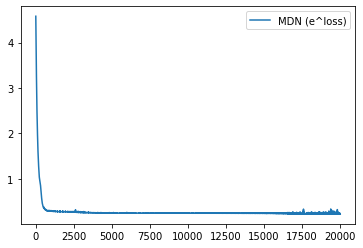

In [95]:
plt.plot(np.exp(mdn_losses), label="MDN (e^loss)")
plt.legend()
plt.show()

In [71]:
torch.save(model.state_dict(), f'mdn_model_nao_{int(EPOCHS/1000)}kepochs_{NGAUSSIANS}gaussians')

In [75]:
class FFN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return self.fc2(x)
        

In [76]:
model_ffn = FFN(n_input=2, n_hidden=6, n_output=2)

In [81]:
ffn_losses = []

In [82]:
def train_ffn(network, x_train, y_train, optimizer, criterion):
    for epoch in range(EPOCHS):
        prediction = network(x_train)
        loss = criterion(prediction, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ffn_losses.append(loss.item())
        if epoch % 500 == 0:
            print(epoch, loss.item())

In [83]:
optimizer = torch.optim.Adam(model_ffn.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() 

train_ffn(model_ffn, dataset.x_train, dataset.y_train, optimizer, criterion)

0 0.003739059902727604
500 0.0036486226599663496
1000 0.00467313127592206
1500 0.004157911986112595
2000 0.0037215091288089752
2500 0.0036104831378906965
3000 0.0038539404049515724
3500 0.0036484403535723686
4000 0.0036622558254748583
4500 0.003615338820964098
5000 0.003644881071522832
5500 0.0035995212383568287
6000 0.0036093927919864655
6500 0.003696027211844921
7000 0.004125307314097881
7500 0.0035987612791359425
8000 0.0036592951510101557
8500 0.003968596458435059
9000 0.0037071406841278076
9500 0.003950983285903931
10000 0.0036661699414253235
10500 0.0036334183532744646
11000 0.0036315275356173515
11500 0.003763132728636265
12000 0.004455239046365023
12500 0.004871994722634554
13000 0.0035859914496541023
13500 0.003637096146121621
14000 0.00364700797945261
14500 0.003942431882023811
15000 0.003658604808151722
15500 0.0037003341130912304
16000 0.004048293922096491
16500 0.0036154421977698803
17000 0.0037260022945702076
17500 0.0037047804798930883
18000 0.004037302918732166
18500 0.

In [84]:
torch.save(model_ffn.state_dict(), f'ffn_model_nao_{int(EPOCHS/1000)}kepochs')

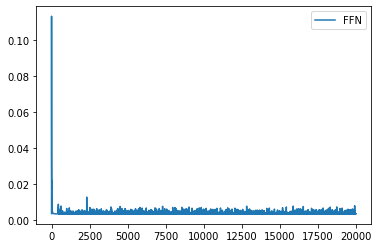

In [90]:
plt.plot(ffn_losses, label="FFN")
plt.legend()
plt.show()